In [1]:
import xarray as xr
import os
import pickle
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib
import warnings
import scipy.stats as sc

In [2]:
#Here, the file headers, start year, and end year are set.
#fileheader depends on where you store your files, and what the name is.
#File paths should be of the form:
#{fileheader}east_ETCs_{k}.pkl

#fileheader = "eastCoast/"
fileheader = "ECERA5/ERA5_ERA5ar_"
startyr = 1950
endyr = 2023

In [3]:
#A quick datetime function
def dt(df):
    return datetime(int(df['year']), int(df['month']), int(df['day']))

In [4]:
np.set_printoptions(suppress=True)

#Save ENSO, PDO data and create a datetime column
enso = pd.read_csv("enso.csv")
enso = enso.set_index('year')

pdo = pd.read_csv("pdo.csv")
pdo = pdo.set_index('Year')


In [5]:
#Storm Months: Quantify how many storms are in each month
storm_months = np.zeros((13))

#ENSO Bomb: Quantify how many storms in each month in El Nino, Neutral, La Nina
#Stats are ETC/30 days, Bomb Cyclone/30 Days, Percent ETCs that become Bomb Cyclones
enso_bomb = np.zeros((13,3,3))

#PDO Bomb: Same as ENSO bomb, except the two states are PDO+, PDO-
pdo_bomb = np.zeros((13,2,3))

#Counting how many storms are in Southeast, Northeast
southeast = 0
northeast = 0

#Classifying storms by Southeast/Northeast, El Nino, Neutral, La Nina,
#and ETC/30 days, Bomb Cyclone/30 Days, Percent ETCs that become Bomb Cyclones
#3 dims, like the other arrays.
enso_bregion = np.zeros((2,3,3))
for k in range(startyr, endyr + 1):
    with open(f"{fileheader}east_ETCs_{k}.pkl", 'rb') as f:
        ETC = pickle.load(f)

    #Considers each storm
    for storm in ETC:

        #Count # of storms in Southeast and Northeast Region
        if (storm['region'] == 'southeast'):
            southeast +=1 
        elif (storm['region'] == 'northeast'):
            northeast +=1 

        #Extract start day of the storm (eliminating the hour)
        start_day = (storm['start_time'] - timedelta(hours=storm['start_time'].hour))

        #Extract ENSO and PDO values on that month/year
        enso_val = float(enso[str(start_day.month)][start_day.year])
        pdo_val = float(enso[str(start_day.month)][start_day.year])

        #did the storm bomb?
        sb = storm['bomb']

        #Counting # of storms per month
        storm_months[start_day.month] += 1

        #To filter by region (right now, it is allowing both regions, northeast AND southeast
        if (storm['region'] == 'northeast' or storm['region'] == 'southeast'):
            #Breaks ENSO values up by El Niño, Neutral, La Niña. Counts ETCs (item 0) and BCs (item 1)
            #Also creates sums overall and by region.
            if (enso_val >= 0.5):
                if sb:
                    enso_bomb[start_day.month,0,1] += 1
                enso_bomb[start_day.month,0,0] += 1
    
                if (storm['region'] == 'southeast'):
                    if sb:
                        enso_bregion[0,0,1] += 1
                    enso_bregion[0,0,0] += 1
                elif (storm['region'] == 'northeast'):
                    if sb:
                        enso_bregion[1,0,1] += 1
                    enso_bregion[1,0,0] += 1
            elif (enso_val > -0.5):
                if sb:
                    enso_bomb[start_day.month,1,1] += 1
                enso_bomb[start_day.month,1,0] += 1
    
                if (storm['region'] == 'southeast'):
                    if sb:
                        enso_bregion[0,1,1] += 1
                    enso_bregion[0,1,0] += 1
                elif (storm['region'] == 'northeast'):
                    if sb:
                        enso_bregion[1,1,1] += 1
                    enso_bregion[1,1,0] += 1
            else:
                if sb:
                    enso_bomb[start_day.month,2,1] += 1
                enso_bomb[start_day.month,2,0] += 1
    
                if (storm['region'] == 'southeast'):
                    if sb:
                        enso_bregion[0,2,1] += 1
                    enso_bregion[0,2,0] += 1
                elif (storm['region'] == 'northeast'):
                    if sb:
                        enso_bregion[1,2,1] += 1
                    enso_bregion[1,2,0] += 1

        #Counts ETCs (item 0) and BCs (item 1) by PDO state (positive or negative)
        if (pdo_val > 0):
            if sb:
                pdo_bomb[start_day.month,0,1] += 1
            pdo_bomb[start_day.month,0,0] += 1
        else:
            if sb:
                pdo_bomb[start_day.month,1,1] += 1
            pdo_bomb[start_day.month,1,0] += 1  

#Item 2: Fraction of ETCs which bomb, by ENSO state, PDO state, ENSO region.
enso_bomb[1:13,:,2] = enso_bomb[1:13,:,1] / enso_bomb[1:13,:,0]
pdo_bomb[1:13,:,2] = pdo_bomb[1:13,:,1] / pdo_bomb[1:13,:,0]
enso_bregion[:,:,2] = enso_bregion[:,:,1] / enso_bregion[:,:,0]

enso_bomb_raw = np.copy(enso_bomb)

#counts the number of months in each ENSO state
enso_states = np.zeros(3)
for y in range(startyr,endyr+1):
    for i in range(1,13):
        val = float(enso[str(i)][y])
        if (val >= 0.5):
            enso_states[0] += 1
        elif (val > -0.5):
            enso_states[1] += 1
        else:
            enso_states[2] += 1

#counts the number of months (splitting by Jan, Feb, ..., Dec) in each ENSO state
enso_states_bymonth = np.zeros((13,3))
for y in range(startyr,endyr+1):
    for i in range(1,13):
        val = float(enso[str(i)][y])
        if (val >= 0.5):
            enso_states_bymonth[i, 0] += 1
        elif (val > -0.5):
            enso_states_bymonth[i, 1] += 1
        else:
            enso_states_bymonth[i, 2] += 1

#counts the number of months (splitting by Jan, Feb, ..., Dec) in each PDO state
pdo_states_bymonth = np.zeros((13,2))
for y in range(startyr,endyr+1):
    for i in range(1,13):
        val = float(enso[str(i)][y])
        if (val >= 0):
            pdo_states_bymonth[i, 0] += 1
        else:
            pdo_states_bymonth[i, 1] += 1

#ENSO: # of ETCS/BCs by region is divided by the number of days in the given ENSO state
enso_bregion[:,0,0:2] = enso_bregion[:,0,0:2] / enso_states[0]
enso_bregion[:,1,0:2] = enso_bregion[:,1,0:2] / enso_states[1]
enso_bregion[:,2,0:2] = enso_bregion[:,2,0:2] / enso_states[2]

for i in range(1,13):
    #ENSO bomb values by month are divided by the number of days in each state per month
    enso_bomb[i,0,0:2] = enso_bomb[i,0,0:2] / enso_states_bymonth[i, 0]
    enso_bomb[i,1,0:2] = enso_bomb[i,1,0:2] / enso_states_bymonth[i, 1]
    enso_bomb[i,2,0:2] = enso_bomb[i,2,0:2] / enso_states_bymonth[i, 2]
    #PDO bomb values by month are divided by the number of days in each state per month
    pdo_bomb[i,0,0:2] = pdo_bomb[i,0,0:2] / pdo_states_bymonth[i, 0]
    pdo_bomb[i,1,0:2] = pdo_bomb[i,1,0:2] / pdo_states_bymonth[i, 1]

In [7]:
#Rearrange months so that winter is in the middle
months = ["July","August","September","October", "November", "December", "January", "February", "March","April","May","June"]
ensow = np.concatenate((enso_bomb[7:13], enso_bomb[1:7]))

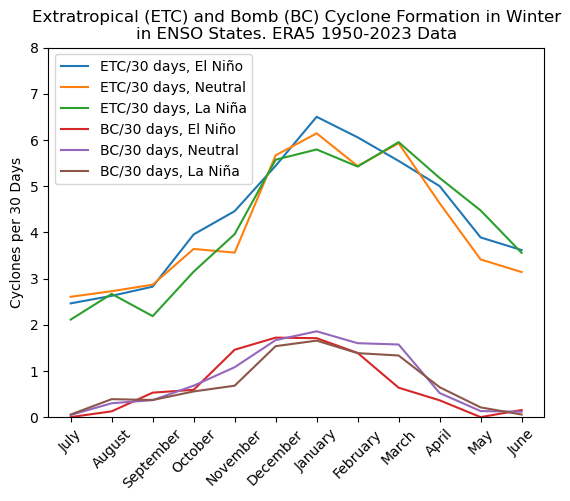

In [8]:
#ETC, BC rates by month
plt.plot(months, ensow[:,0,0], label="ETC/30 days, El Niño")
plt.plot(months, ensow[:,1,0], label="ETC/30 days, Neutral")
plt.plot(months, ensow[:,2,0], label="ETC/30 days, La Niña")

plt.plot(months, ensow[:,0,1], label="BC/30 days, El Niño")
plt.plot(months, ensow[:,1,1], label="BC/30 days, Neutral")
plt.plot(months, ensow[:,2,1], label="BC/30 days, La Niña")
plt.legend()

plt.xticks(months, rotation=45)
plt.ylabel("Cyclones per 30 Days")
plt.ylim((0,8))
plt.title("Extratropical (ETC) and Bomb (BC) Cyclone Formation in Winter\nin ENSO States. ERA5 1950-2023 Data")
plt.savefig("figures/ENSO_ETC_BC_ERA5.png")

In [9]:
#Classifying storms by Southeast/Northeast, El Nino, Neutral, La Nina,
#and ETC/30 days, Bomb Cyclone/30 Days, Percent ETCs that become Bomb Cyclones
#3 dims, like the other arrays.
enso_bregion

array([[[0.86206897, 0.29064039, 0.33714286],
        [0.75970874, 0.22815534, 0.30031949],
        [0.81318681, 0.27472527, 0.33783784]],

       [[3.6453202 , 0.60098522, 0.16486486],
        [3.25      , 0.48058252, 0.14787155],
        [3.42124542, 0.53479853, 0.15631692]]])

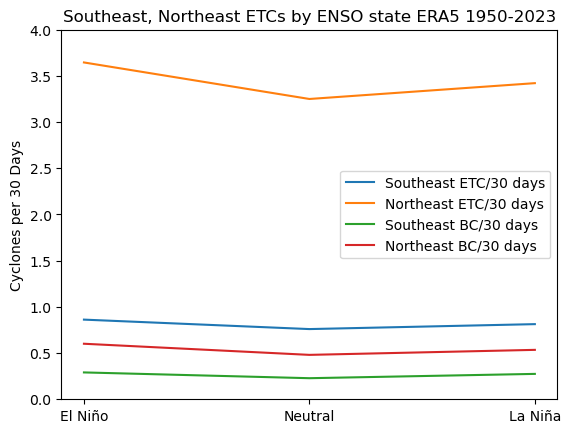

In [10]:
#ETC, BC rate by ENSO state, Northeast vs Southeast
enso_phases = ["El Niño", "Neutral", "La Niña"]
plt.plot(enso_phases, enso_bregion[0,:,0], label="Southeast ETC/30 days")
plt.plot(enso_phases, enso_bregion[1,:,0], label="Northeast ETC/30 days")
plt.plot(enso_phases, enso_bregion[0,:,1], label="Southeast BC/30 days")
plt.plot(enso_phases, enso_bregion[1,:,1], label="Northeast BC/30 days")
plt.legend()
plt.title("Southeast, Northeast ETCs by ENSO state ERA5 1950-2023")
plt.ylabel("Cyclones per 30 Days")
plt.ylim((0,4))
plt.savefig("figures/ENSOstatesSoutheastNortheast.png")

In [9]:
#number of months in each ENSO state
enso_states

array([203., 412., 273.])

In [10]:
#fraction of days in each ENSO state by month
enso_dist = np.zeros((13,3))
for i in range(1,13):
    enso_dist[i,0] = len(enso[str(i)][enso[str(i)] >= 0.5])
    enso_dist[i,1] = len(enso[str(i)][abs(enso[str(i)]) < 0.5])
    enso_dist[i,2] = len(enso[str(i)][enso[str(i)] <= -0.5])
for i in range(1,13):
    enso_dist[i] = enso_dist[i] / enso_dist[i].sum()

In [11]:
enso_dist

array([[0.        , 0.        , 0.        ],
       [0.32432432, 0.28378378, 0.39189189],
       [0.24324324, 0.40540541, 0.35135135],
       [0.14864865, 0.56756757, 0.28378378],
       [0.14864865, 0.62162162, 0.22972973],
       [0.12162162, 0.62162162, 0.25675676],
       [0.17567568, 0.58108108, 0.24324324],
       [0.17567568, 0.58108108, 0.24324324],
       [0.21621622, 0.54054054, 0.24324324],
       [0.22972973, 0.40540541, 0.36486486],
       [0.2972973 , 0.33783784, 0.36486486],
       [0.32432432, 0.33783784, 0.33783784],
       [0.33783784, 0.28378378, 0.37837838]])

In [18]:
def dt(df):
    return datetime(int(df['year']), int(df['month']), int(df['day']))

#Read in NAO, AO, PNA data
ao = pd.read_csv("ao.csv")
nao = pd.read_csv("nao.csv")
pna = pd.read_csv("pna.csv")
ao['datetime'] = ao.apply(dt, axis=1)
nao['datetime'] = nao.apply(dt, axis=1)
pna['datetime'] = pna.apply(dt, axis=1)

In [19]:
#Determine the amplitude. only adds to - + stats with an amplitude greater than this.
amp = 0.5

warnings.filterwarnings('ignore')

#NAO, AO rates of ETC, BC formation (per 30 days) plus fraction of ETC which become BC, by state (+ vs -)
nao_bomb = np.zeros((13,2,3))
ao_bomb = np.zeros((13,2,3))
pna_bomb = np.zeros((13,2,3))
southeast = 0
northeast = 0
for k in range(startyr, endyr + 1):
    with open(f"{fileheader}east_ETCs_{k}.pkl", 'rb') as f:
        ETC = pickle.load(f)

    ETCnew = list()
    for storm in ETC:
        if (storm['region'] == 'southeast'):
            southeast +=1 
        elif (storm['region'] == 'northeast'):
            northeast +=1 

        #extract start day (minus the hour)
        start_day = (storm['start_time'] - timedelta(hours=storm['start_time'].hour))

        #extract NAO, AO, PNA values on that day
        nao_val = float(nao[nao['datetime'] == start_day]['nao_index_cdas'].iloc[0])
        ao_val = float(ao[ao['datetime'] == start_day]['ao_index_cdas'].iloc[0])
        pna_val = float(pna[pna['datetime'] == start_day]['pna_index_cdas'].iloc[0])

        #does the storm experience bombogenesis?
        sb = storm['bomb']

        #Adds ETC, BC for positive or negative NAO state
        if (nao_val >= amp):
            if sb:
                nao_bomb[start_day.month,0,1] += 1
            nao_bomb[start_day.month,0,0] += 1
        elif (nao_val <= -amp):
            if sb:
                nao_bomb[start_day.month,1,1] += 1
            nao_bomb[start_day.month,1,0] += 1    

        #Adds ETC, BC for positive or negative AO state
        if (ao_val >= amp):
            if sb:
                ao_bomb[start_day.month,0,1] += 1
            ao_bomb[start_day.month,0,0] += 1
        elif (ao_val <= -amp):
            if sb:
                ao_bomb[start_day.month,1,1] += 1
            ao_bomb[start_day.month,1,0] += 1 

        #Adds ETC, BC for positive or negative PNA state
        if (pna_val >= amp):
            if sb:
                pna_bomb[start_day.month,0,1] += 1
            pna_bomb[start_day.month,0,0] += 1
        elif (pna_val <= -amp):
            if sb:
                pna_bomb[start_day.month,1,1] += 1
            pna_bomb[start_day.month,1,0] += 1      

#Calculates percent of ETCs which experience bombogenesis
nao_bomb[1:13,:,2] = nao_bomb[1:13,:,1] / nao_bomb[1:13,:,0]
ao_bomb[1:13,:,2] = ao_bomb[1:13,:,1] / ao_bomb[1:13,:,0]
pna_bomb[1:13,:,2] = pna_bomb[1:13,:,1] / pna_bomb[1:13,:,0]

#calculates the number of days per month (across all years) with NAO/AO/PNA+ and NAO/AO/PNA- greater than given amplitude
nao_days = np.zeros((13,2))
ao_days = np.zeros((13,2))
pna_days = np.zeros((13,2))
for a in range(1,13):
    nao_days[a, 0] = len(nao[nao['month'] == a][nao['nao_index_cdas'] >= amp][nao['year'] >= startyr][nao['year'] <= endyr])
    nao_days[a, 1] = len(nao[nao['month'] == a][nao['nao_index_cdas'] <= -amp][nao['year'] >= startyr][nao['year'] <= endyr])
    ao_days[a, 0] = len(ao[ao['month'] == a][ao['ao_index_cdas'] >= amp][nao['year'] >= startyr][nao['year'] <= endyr])
    ao_days[a, 1] = len(ao[ao['month'] == a][ao['ao_index_cdas'] <= -amp][nao['year'] >= startyr][nao['year'] <= endyr])
    pna_days[a, 0] = len(pna[pna['month'] == a][pna['pna_index_cdas'] >= amp][nao['year'] >= startyr][nao['year'] <= endyr])
    pna_days[a, 1] = len(pna[pna['month'] == a][pna['pna_index_cdas'] <= -amp][nao['year'] >= startyr][nao['year'] <= endyr])

#copies these so the bomb values can be divided to get storm rate
nao_bomb_raw = np.copy(nao_bomb)
ao_bomb_raw = np.copy(ao_bomb)
pna_bomb_raw = np.copy(pna_bomb)

#divides bomb tables to get storm formation rate per 30 days
for a in range(1,13):
    for b in range(2):
        nao_bomb[a,b,0:2] = nao_bomb[a,b,0:2] / nao_days[a,b] * 30
        ao_bomb[a,b,0:2] = ao_bomb[a,b,0:2] / ao_days[a,b] * 30
        pna_bomb[a,b,0:2] = pna_bomb[a,b,0:2] / pna_days[a,b] * 30

In [12]:
enso_bomb

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[6.5       , 1.70833333, 0.26282051],
        [6.14285714, 1.85714286, 0.30232558],
        [5.79310345, 1.65517241, 0.28571429]],

       [[6.05555556, 1.38888889, 0.2293578 ],
        [5.43333333, 1.6       , 0.29447853],
        [5.42307692, 1.38461538, 0.25531915]],

       [[5.54545455, 0.63636364, 0.1147541 ],
        [5.92857143, 1.57142857, 0.26506024],
        [5.95238095, 1.33333333, 0.224     ]],

       [[5.        , 0.36363636, 0.07272727],
        [4.63043478, 0.52173913, 0.11267606],
        [5.17647059, 0.64705882, 0.125     ]],

       [[3.88888889, 0.        , 0.        ],
        [3.41304348, 0.13043478, 0.03821656],
        [4.47368421, 0.21052632, 0.04705882]],

       [[3.61538462, 0.15384615, 0.04255319],
        [3.13953488, 0.11627907, 0.03703704],
        [3.55555556, 0.05555556, 0.015625  ]],

       [[2.46153846,

In [22]:
#EXTRATROPICAL CYCLONE BLOCK

#Choose the set of months for analysis {we're using extended winter generally, (1,2,3,10,11,12)}
months = (1,2,3,10,11,12)
#months = (12,1,2)

#Analysis: Get results vs expected values for number of ETCs in positive/negative phases of these oscillations
#Have both rounded, so the Chi-Square Test can be used.
#ENSO additionally has a neutral phase.
nao_analysis = np.array([[nao_days[months,0].sum(),nao_days[months,1].sum()],
                       [nao_bomb_raw[months,0,0].sum(), nao_bomb_raw[months,1,0].sum()]])
nao_analysis[0] = np.round(nao_analysis[0] / nao_analysis[0].sum() * nao_analysis[1].sum())


ao_analysis = np.array([[ao_days[months,0].sum(),ao_days[months,1].sum()],
                       [ao_bomb_raw[months,0,0].sum(), ao_bomb_raw[months,1,0].sum()]])
ao_analysis[0] = np.round(ao_analysis[0] / ao_analysis[0].sum() * ao_analysis[1].sum())


pna_analysis = np.array([[pna_days[months,0].sum(),pna_days[months,1].sum()],
                       [pna_bomb_raw[months,0,0].sum(), pna_bomb_raw[months,1,0].sum()]])
pna_analysis[0] = np.round(pna_analysis[0] / pna_analysis[0].sum() * pna_analysis[1].sum())


enso_analysis = np.array([[enso_states_bymonth[months,0].sum() * 30,enso_states_bymonth[months,1].sum() * 30, enso_states_bymonth[months,2].sum() * 30],
                       [enso_bomb_raw[months,0,0].sum(), enso_bomb_raw[months,1,0].sum(), enso_bomb_raw[months,2,0].sum()]])
enso_analysis[0] = np.round(enso_analysis[0] / enso_analysis[0].sum() * enso_analysis[1].sum())
if (months == (12,1,2)):
    enso_analysis[0,2] += 1


In [24]:
#NAO, AO, PNA, ENSO ETC differences and p-values
print("NAO",sc.chisquare(nao_analysis[1], nao_analysis[0]))
print("AO",sc.chisquare(ao_analysis[1], ao_analysis[0]))
print("PNA",sc.chisquare(pna_analysis[1], pna_analysis[0]))
print("ENSO",sc.chisquare(enso_analysis[1], enso_analysis[0]))

NAO Power_divergenceResult(statistic=np.float64(7.875613880773621), pvalue=np.float64(0.0050105859305749016))
AO Power_divergenceResult(statistic=np.float64(7.9635048960820916), pvalue=np.float64(0.004772989993945346))
PNA Power_divergenceResult(statistic=np.float64(34.34568345323741), pvalue=np.float64(4.614226168857169e-09))
ENSO Power_divergenceResult(statistic=np.float64(1.4899847210310244), pvalue=np.float64(0.47473792667908576))


In [25]:
#BOMB CYCLONE BLOCK

#Analysis: Get results vs expected values for number of BCs in positive/negative phases of these oscillations
#Have both rounded, so the Chi-Square Test can be used.
#ENSO additionally has a neutral phase.
nao_analysis = np.array([[nao_days[months,0].sum(),nao_days[months,1].sum()],
                       [nao_bomb_raw[months,0,1].sum(), nao_bomb_raw[months,1,1].sum()]])
nao_analysis[0] = np.round(nao_analysis[0] / nao_analysis[0].sum() * nao_analysis[1].sum())

ao_analysis = np.array([[ao_days[months,0].sum(),ao_days[months,1].sum()],
                       [ao_bomb_raw[months,0,1].sum(), ao_bomb_raw[months,1,1].sum()]])
ao_analysis[0] = np.round(ao_analysis[0] / ao_analysis[0].sum() * ao_analysis[1].sum())

pna_analysis = np.array([[pna_days[months,0].sum(),pna_days[months,1].sum()],
                       [pna_bomb_raw[months,0,1].sum(), pna_bomb_raw[months,1,1].sum()]])
pna_analysis[0] = np.round(pna_analysis[0] / pna_analysis[0].sum() * pna_analysis[1].sum())

enso_analysis = np.array([[enso_states_bymonth[months,0].sum() * 30,enso_states_bymonth[months,1].sum() * 30, enso_states_bymonth[months,2].sum() * 30],
                       [enso_bomb_raw[months,0,1].sum(), enso_bomb_raw[months,1,1].sum(), enso_bomb_raw[months,2,1].sum()]])
enso_analysis[0] = np.round(enso_analysis[0] / enso_analysis[0].sum() * enso_analysis[1].sum())


In [26]:
#NAO, AO, PNA, ENSO BC differences and p-values

print("NAO",sc.chisquare(nao_analysis[1], nao_analysis[0]))
print("AO",sc.chisquare(ao_analysis[1], ao_analysis[0]))
print("PNA",sc.chisquare(pna_analysis[1], pna_analysis[0]))
print("ENSO",sc.chisquare(enso_analysis[1], enso_analysis[0]))

NAO Power_divergenceResult(statistic=np.float64(0.012981162981162982), pvalue=np.float64(0.9092893941258265))
AO Power_divergenceResult(statistic=np.float64(0.14305627464255843), pvalue=np.float64(0.7052613694883338))
PNA Power_divergenceResult(statistic=np.float64(4.895001478852411), pvalue=np.float64(0.02693455037051253))
ENSO Power_divergenceResult(statistic=np.float64(2.93080882071483), pvalue=np.float64(0.23098456003780038))


In [27]:
etc_counts = np.zeros((13,2))
for a in range(1,13):    
    etc_counts[a, 0] = enso_bomb[a,:,0].sum()
    etc_counts[a, 1] = enso_bomb[a,:,1].sum()
etc_counts = etc_counts / (endyr - startyr + 1)

In [28]:
etc_counts

array([[0.        , 0.        ],
       [0.2491346 , 0.07054931],
       [0.22854008, 0.05910141],
       [0.23549199, 0.04785305],
       [0.20009332, 0.02070857],
       [0.15912995, 0.00460758],
       [0.13933074, 0.00440109],
       [0.09699055, 0.00137929],
       [0.10833333, 0.0109985 ],
       [0.10642407, 0.01711417],
       [0.14517154, 0.02468195],
       [0.16186937, 0.04349099],
       [0.22537967, 0.06651866]])

In [29]:
#reorganize months so that winter is in the middle

months = ["October", "November", "December", "January", "February", "March"]
months = ["July","August","September","October", "November", "December", "January", "February", "March","April","May","June"]
naow = np.concatenate((nao_bomb[7:13], nao_bomb[1:7]))
aow = np.concatenate((ao_bomb[7:13], ao_bomb[1:7]))
pnaw = np.concatenate((pna_bomb[7:13], pna_bomb[1:7]))

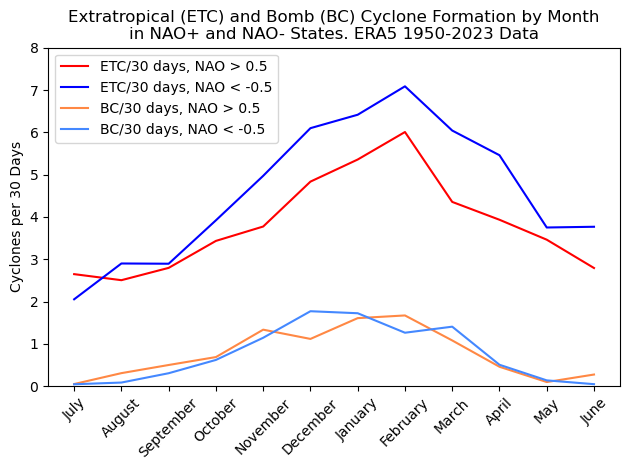

In [33]:
#NAO state vs ETC/BC frequency plot

plt.plot(months, naow[:,0,0], label="ETC/30 days, NAO > 0.5", color="#FF0000")
plt.plot(months, naow[:,1,0], label="ETC/30 days, NAO < -0.5", color="#0000FF")

plt.plot(months, naow[:,0,1], label="BC/30 days, NAO > 0.5", color="#FF8844")
plt.plot(months, naow[:,1,1], label="BC/30 days, NAO < -0.5", color="#4488FF")
plt.legend()

plt.xticks(months, rotation=45)
plt.ylabel("Cyclones per 30 Days")
plt.ylim((0,8))
plt.title("Extratropical (ETC) and Bomb (BC) Cyclone Formation by Month\nin NAO+ and NAO- States. ERA5 1950-2023 Data")
plt.tight_layout()
plt.savefig("figures/NAO_ETC_BC_ERA5.png")

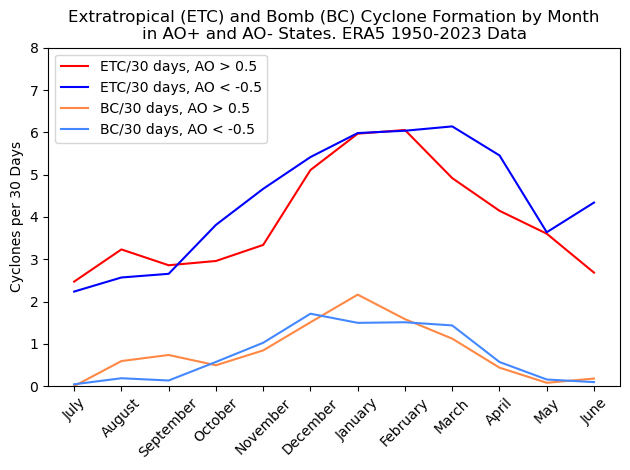

In [34]:
#AO state vs ETC/BC frequency plot

plt.plot(months, aow[:,0,0], label="ETC/30 days, AO > 0.5", color="#FF0000")
plt.plot(months, aow[:,1,0], label="ETC/30 days, AO < -0.5", color="#0000FF")

plt.plot(months, aow[:,0,1], label="BC/30 days, AO > 0.5", color="#FF8844")
plt.plot(months, aow[:,1,1], label="BC/30 days, AO < -0.5", color="#4488FF")
plt.legend()

plt.xticks(months, rotation=45)
plt.ylabel("Cyclones per 30 Days")
plt.ylim((0,8))
plt.title("Extratropical (ETC) and Bomb (BC) Cyclone Formation by Month\nin AO+ and AO- States. ERA5 1950-2023 Data")
plt.tight_layout()
plt.savefig("figures/AO_ETC_BC_ERA5.png")

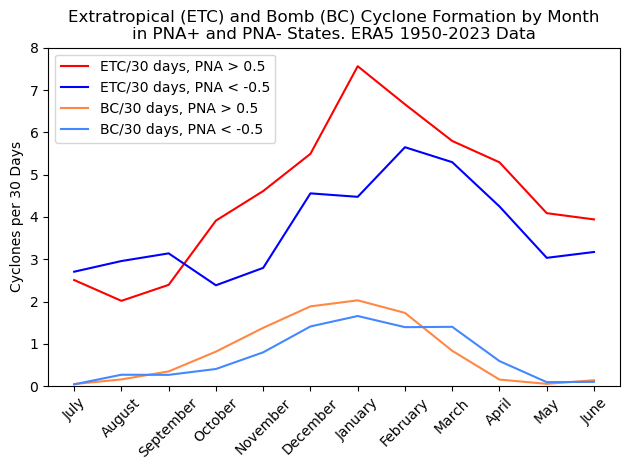

In [35]:
#PNA state vs ETC/BC frequency plot

plt.plot(months, pnaw[:,0,0], label="ETC/30 days, PNA > 0.5", color="#FF0000")
plt.plot(months, pnaw[:,1,0], label="ETC/30 days, PNA < -0.5", color="#0000FF")

plt.plot(months, pnaw[:,0,1], label="BC/30 days, PNA > 0.5", color="#FF8844")
plt.plot(months, pnaw[:,1,1], label="BC/30 days, PNA < -0.5", color="#4488FF")
plt.legend()

plt.xticks(months, rotation=45)
plt.ylabel("Cyclones per 30 Days")
plt.ylim((0,8))
plt.title("Extratropical (ETC) and Bomb (BC) Cyclone Formation by Month\nin PNA+ and PNA- States. ERA5 1950-2023 Data")
plt.tight_layout()
plt.savefig("figures/PNA_ETC_BC_ERA5.png")